In [1]:
import torch
from model_triton import *

dloss_dx = torch.randn((8, 512, 768), device="cuda")
#dloss_dx = torch.randn((1, 768), device="cuda")
#Two shapes are being used: [8, 12, 512, 512], and 4096, 35374
layer_params = (torch.randn((768), device="cuda"), torch.randn((768), device="cuda"))
#aa = torch.randn((2, 768), device="cuda")
aa = torch.randn((8, 512, 768), device="cuda")
#aa = torch.randn((1, 768), device="cuda")
#aa = torch.randn((4096, 35374), device="cuda")
#aa = aa.view(-1)
N = 1 #100

from functools import partial
def fn_naive(dloss_dx, x):
    return t_layernorm_bkwd2_p(dloss_dx, layer_params, x)
fn_jit = torch.compile(fn_naive)
# burn it
#fn_jit(aa) 
fn_jit(dloss_dx, aa) 

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_jit(aa)
        result = fn_jit(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_jit(aa)
    result = fn_jit(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N):
    #result = fn_naive(aa)
    result = fn_naive(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
       Torch-Compiled Region: 0/0        92.11%       1.796ms        96.68%       1.885ms       1.885ms       0.000us         0.00%     119.326us     119.326us             1  
          t_layernorm_bkwd2_p_k_0         0.72%      13.981us         1.05%      20.491us      20.491us     116.318us        97.48%     116.318us     116.318us             1  
            t_layernorm_bkwd2_p_k         0.00%       0.000us         0.00%       0.000us       0.000us     116.318us  

In [2]:
# import triton
# print(triton.runtime.driver.active.get_current_target())
# device = "cuda" #triton.runtime.driver.active.get_active_torch_device()
# properties = triton.runtime.driver.active.utils.get_device_properties(device)
# See https://github.com/triton-lang/triton/issues/5628, and https://github.com/triton-lang/triton/issues/5388
# properties

In [2]:
import triton
import triton.language as tl

# Note that the kernel assumes that n_cols < BLOCK_SIZE
# TODO T: investigate numerical differences from torch.func implementation
@triton.jit
def t_layernorm_bkwd2_p_k(dloss_dx_ptr,
                    x_ptr,
                    output1_ptr,
                    output2_ptr,                          
                    dloss_dx_stride,
                    x_row_stride,                        
                    n_rows,
                    n_cols,
                    BLOCK_SIZE: tl.constexpr,
                    num_stages: tl.constexpr,
                    ):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    
    offsets = tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_cols
    
    # TODO T: how much this is being reused?
    _output1 = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
    _output2 = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
        
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages):
        dloss_dx_row_start_ptr = dloss_dx_ptr + row_idx * dloss_dx_stride
        dloss_dx = tl.load(dloss_dx_row_start_ptr + offsets, mask=mask, other=0.0)
        x_row_start_ptr = x_ptr + row_idx * x_row_stride    
        x = tl.load(x_row_start_ptr + offsets, mask=mask, other=0.0)
        
        # compute mean and std for x
        x_sum = tl.sum(x, axis=0)
        x_mu = x_sum/ n_cols
        x_minus_mu = x - x_mu
        x_minus_mu2 = x_minus_mu * x_minus_mu
        x_minus_mu2_sum = tl.sum(x_minus_mu2, axis=0)
        x_sigma2 = x_minus_mu2_sum / (n_cols-1)
        x_sigma = tl.sqrt_rn(x_sigma2)
        
        # normalize x
        x_norm = x_minus_mu/x_sigma    
        
        _output1 += dloss_dx * x_norm
        _output2 += dloss_dx
    
    # TODO T: Should we add parallel reduction strategy here: save to partial GROUP_SIZE_M sums first, before summing it up?
    tl.atomic_add(output1_ptr + offsets, _output1, mask=mask)
    tl.atomic_add(output2_ptr + offsets, _output2, mask=mask)    
    
def t_layernorm_bkwd2_p_t(dloss_dx:torch.Tensor, layer_params: torch.Tensor, x: torch.Tensor):
    # TODO T: without this reshape, this func is 2times faster?
    dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1]))
    x_2d = x.reshape((-1, x.shape[-1])) 
    n_rows, n_cols = x_2d.shape
    BLOCK_SIZE = triton.next_power_of_2(n_cols) 
    output1 = torch.zeros_like(layer_params[0])
    output2 = torch.zeros_like(layer_params[1])    
    
    # TODO T: The below numbers were tuned for A10 by choosing num_warps=8
    num_warps = 8
    num_stages = 2
    num_programs = min(n_rows, 480) 
    t_layernorm_bkwd2_p_k[(num_programs,)](dloss_dx_2d, x_2d, output1, output2, 
                                       dloss_dx_2d.stride(0), x_2d.stride(0), n_rows, n_cols, 
                                       BLOCK_SIZE=BLOCK_SIZE, num_warps=num_warps, num_stages=num_stages)
    return output1, output2 

def fn_t(dloss_dx, x):
    return t_layernorm_bkwd2_p_t(dloss_dx, layer_params, x)

from torch.profiler import profile, record_function, ProfilerActivity, schedule
activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
with profile(activities=activities, record_shapes=True) as prof:
    for _ in range(N):
        #result = fn_t(aa)
        result = fn_t(dloss_dx, aa)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

import time
t0 = time.time()
for _ in range(N):
    #result = fn_t(aa)
    result = fn_t(dloss_dx, aa)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  t_layernorm_bkwd2_p_k         0.00%       0.000us         0.00%       0.000us       0.000us      93.472us        96.91%      93.472us      93.472us             1  
                                       aten::zeros_like        18.61%     811.503us        98.31%       4.287ms       2.144ms       0.000us         0.00%       2.976us       1.488us             2  
         

In [3]:
#res1 = fn_jit(aa)
res1 = fn_jit(dloss_dx, aa)
#res2 = fn_t(aa)
res2 = fn_t(dloss_dx, aa)


assert torch.allclose(res1[0], res2[0], atol=1e-2, rtol=0), (res1[0].shape, res2[0].shape, res1[0][:100], res2[0][:100])
assert torch.allclose(res1[1], res2[1], atol=1e-2, rtol=0), (res1[1].shape, res2[1].shape, res1[1][:100], res2[1][:100])
#assert torch.allclose(res1, res2), (res1[0], res2[0])
print(f'res1', res1[0].shape, res1[0][:100])
print(f'res2', res2[0].shape, res2[0][:100])

res1 torch.Size([768]) tensor([  95.1687,  -25.0189,  -59.5536,   43.9867,   -1.0060,  -11.9509,
          29.2568,   37.7534,  -32.6870,    1.8032,  -11.9498,   -9.6395,
         -22.2823,   36.5493,  -50.3863,   -2.3215,   16.2722,  161.2084,
           4.1640,  -92.0618,  143.4859,  -52.1562,  -28.1901,  -90.8348,
          33.8247,   11.2040,   52.2683,   -7.9592, -109.8448,   -5.5466,
          18.1443,    7.8433,  148.9875,   22.3122,   56.9081,    8.9039,
          11.6286,   -2.4500,  -25.6496,   32.2235,   -0.3576, -130.9826,
          53.0317,   65.4559,   84.4505,   41.9895, -100.6363,   11.3724,
           4.3540,  -67.5684,  -54.6326,  -83.4864,   93.3548,   30.4224,
         119.0786,  -46.5971,  -59.4636, -111.6934,  -91.6971,  -79.6589,
         -68.4512,  112.8705,   87.5746,  -25.3938,  -30.1264,  -16.2564,
         -90.3486,   69.9113,  -82.8568,   -4.0096,  -20.9173,  -65.0024,
         -46.2275,   11.9035,   43.8028,   18.2876,  -44.1837,   39.7555,
         -48.26

In [13]:
print(res1[1][:100])

tensor([  24.4056,  -40.0551,  -10.6713,   40.7296,  -93.1700,  -37.2333,
         -16.0784,  -37.0965,   68.9446,  -34.1143,   -8.0013,   87.3877,
           7.0199,   -1.1236,    1.1803,   -8.4736,   45.7447,  -49.6264,
          47.9383,   56.9961,   30.9900,  -41.3200,  -68.3624,   14.3464,
         -62.5568,   26.7465,  -68.7216,  109.0114,  -74.8925,   75.0364,
          68.8853,  111.5215,   22.3440,  -43.0244,   76.2037,  -21.0002,
         -52.6470,  -14.3917,  -32.5757,  -78.8080,  -60.3404,  -29.6343,
          29.0757,  -14.0219,  -24.4524,   59.0663,   71.7406,  111.2338,
         -30.9470,  -27.4130,   60.2276,  -16.4526,  -93.9371,   71.3842,
          -5.0634,  -11.1472,   17.0944,   90.8599,  -57.7976,  -26.7024,
         -33.0511,  -72.8697,  116.0010,   62.7593,  151.1949,  -53.2054,
          86.0129,   18.3840,  -93.3876,   20.7278,  -20.6406, -144.1550,
          30.9153,   36.3842,  -69.4481,  -25.1651,   89.7278,   17.8879,
          10.0968, -110.9552,  -12.054

In [14]:
print(res2[1][:100])

tensor([  24.4056,  -40.0551,  -10.6713,   40.7296,  -93.1700,  -37.2333,
         -16.0784,  -37.0965,   68.9446,  -34.1143,   -8.0013,   87.3877,
           7.0199,   -1.1236,    1.1803,   -8.4736,   45.7447,  -49.6264,
          47.9383,   56.9961,   30.9900,  -41.3200,  -68.3623,   14.3464,
         -62.5568,   26.7465,  -68.7216,  109.0113,  -74.8926,   75.0364,
          68.8853,  111.5216,   22.3440,  -43.0244,   76.2037,  -21.0002,
         -52.6470,  -14.3917,  -32.5757,  -78.8079,  -60.3405,  -29.6343,
          29.0757,  -14.0219,  -24.4524,   59.0663,   71.7407,  111.2338,
         -30.9470,  -27.4131,   60.2276,  -16.4526,  -93.9371,   71.3841,
          -5.0634,  -11.1472,   17.0943,   90.8599,  -57.7976,  -26.7024,
         -33.0511,  -72.8697,  116.0010,   62.7593,  151.1948,  -53.2054,
          86.0128,   18.3840,  -93.3876,   20.7278,  -20.6406, -144.1550,
          30.9153,   36.3843,  -69.4481,  -25.1651,   89.7277,   17.8879,
          10.0968, -110.9551,  -12.054

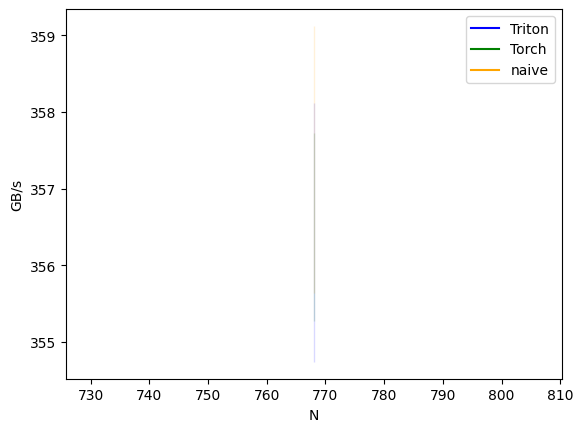

t_dropout_fwd:
       N      Triton       Torch       naive
0  768.0  356.173905  356.496821  357.036318


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # Argument names to use as an x-axis for the plot.
        x_vals=[768], #[128 * i for i in range(2, 100)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='t_dropout_fwd',  # Name for the plot. Used also as a file name for saving the plot.
        args={'M':4096},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(M, N, provider):
    dloss_dx = torch.rand(M, N, device="cuda", dtype=torch.float32)    
    x = torch.rand(M, N, device="cuda", dtype=torch.float32)
    stream = getattr(torch, "cuda").Stream() # TODO XXX XXX: what is this stream about?
    getattr(torch, "cuda").set_stream(stream)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
    if provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(x), quantiles=quantiles)        
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
    if provider == 'naive':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(x), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [5]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=61ea3d2d-53a8-44f6-4844-0bcc29aa720b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [6]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
dloss_dx_2d = dloss_dx.reshape((-1, dloss_dx.shape[-1]))
x_2d = aa.reshape((-1, aa.shape[-1])) # TODO T: without this reshape, this func is 2times faster
n_rows, n_cols = x_2d.shape
BLOCK_SIZE = triton.next_power_of_2(n_cols) 
output1 = torch.zeros_like(layer_params[0])
output2 = torch.zeros_like(layer_params[1]) 
print(f'num_stages', num_stages, 'num_warps', num_warps)

kernel = t_layernorm_bkwd2_p_k.warmup(dloss_dx_2d, x_2d, output1, output2, 
                                        dloss_dx_2d.stride(0), x_2d.stride(0), 
                                        n_rows, n_cols, BLOCK_SIZE=BLOCK_SIZE,
                                        num_stages=num_stages, num_warps=num_warps, grid=(1, ))
kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
size_smem = max(1, size_smem) # accounts for divisiion by 0 below. size_smem=0 is possible
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8
n_regs 39 size_smem 8224
occupancy 6 12
num_programs 480


In [ ]:
32
2080
4128
6176